# Table of Contents: <a class="anchor" id="contents"></a> 

* [Importing and cleaning data](#import)
* [Descriptive Stats](#descr)
* [Logistic Regression RFE](#logisticrfe)
    * [HNHC](#lrhnhc)
    * [HNHC no 'los'](#lrhnhcnolos)
    * [IBD_READM](#lrreadm)
    * [IBD_READM no 'los'](#lrreadmnolos)
* [Decision Tree RFE](#decisiontreerfe)
    * [HNHC](#dthnhc)
    * [HNHC no 'los'](#dthnhcnolos)
    * [IBD_READM](#dtreadm)
    * [IBD_READM no 'los'](#dtreadmnolos)
* [XGBoost RFE](#xgboostrfe)
    * [HNHC](#xgbhnhc)
    * [HNHC no 'los'](#xgbhnhcnolos)
    * [IBD_READM](#xgbreadm)
    * [IBD_READM no 'los'](#xgbreadmnolos)

## Importing and cleaning data <a class="anchor" id="import"></a>

[Return to Table of Contents](#contents)

In [1]:
# Import dependencies
from sklearn import tree
import pandas as pd
import numpy as np
import os
import warnings
import timeit
import dask.dataframe as dd
from IPython.display import display 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
# Read in the data as a dataframe.
df = pd.read_csv('NRD 2013 (machine learning).csv')
df.head()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [3]:
# Create a list of the column names and print it out.
variables = df.columns.values
print(variables)

['index' 'age' 'aweekend' 'died' 'discwt' 'dispuniform' 'dmonth' 'dqtr'
 'drg' 'drgver' 'drg_nopoa' 'dx1' 'dx2' 'dx3' 'dx4' 'dx5' 'dx6' 'dx7'
 'dx8' 'dx9' 'dx10' 'dx11' 'dx12' 'dx13' 'dx14' 'dx15' 'dx16' 'dx17'
 'dx18' 'dx19' 'dx20' 'dx21' 'dx22' 'dx23' 'dx24' 'dx25' 'dxccs1' 'dxccs2'
 'dxccs3' 'dxccs4' 'dxccs5' 'dxccs6' 'dxccs7' 'dxccs8' 'dxccs9' 'dxccs10'
 'dxccs11' 'dxccs12' 'dxccs13' 'dxccs14' 'dxccs15' 'dxccs16' 'dxccs17'
 'dxccs18' 'dxccs19' 'dxccs20' 'dxccs21' 'dxccs22' 'dxccs23' 'dxccs24'
 'dxccs25' 'elective' 'female' 'hcup_ed' 'hosp_nrd' 'key_nrd' 'los' 'mdc'
 'mdc_nopoa' 'nchronic' 'ndx' 'necode' 'npr' 'nrd_daystoevent'
 'nrd_stratum' 'nrd_visitlink' 'orproc' 'pay1' 'pl_nchs' 'pr1' 'pr2' 'pr3'
 'pr4' 'pr5' 'pr6' 'pr7' 'pr8' 'pr9' 'pr10' 'pr11' 'pr12' 'pr13' 'pr14'
 'pr15' 'prccs1' 'prccs2' 'prccs3' 'prccs4' 'prccs5' 'prccs6' 'prccs7'
 'prccs8' 'prccs9' 'prccs10' 'prccs11' 'prccs12' 'prccs13' 'prccs14'
 'prccs15' 'rehabtransfer' 'resident' 'samedayevent' 'totchg' 'year'
 'zip

In [4]:
# Look at the ibd_specific_adm column
df['ibd_specific_adm']

0        0
1        0
2        0
3        1
4        1
        ..
94493    1
94494    0
94495    0
94496    0
94497    1
Name: ibd_specific_adm, Length: 94498, dtype: int64

In [5]:
# Make a copy of the dataframe
df_copy = df.copy()
df_copy.head()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [6]:
# Check the back end of the data
df_copy.tail()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [7]:
# Check the data 
# Looks like the ibd_readm variables contains "NA" values

df_copy[['nrd_visitlink','ibd_index_hosp', 'dx1', 'new_mi_adm', 'ibd_readm']].head()

,nrd_visitlink,ibd_index_hosp,dx1,new_mi_adm,ibd_readm
0,00017u,1,00845,0,0
1,00017u,0,0389,0,1
2,00017u,0,03842,0,1
3,0004o5,1,5559,0,0
4,000dbz,1,5559,0,0


In [8]:
# Recoding the ibd_readm outcome variable
readm_set = set()
for index, row in df_copy[['nrd_visitlink','ibd_readm']].iterrows():
    if row[1] == 1:
        readm_set.add(row[0])
        
readm_list = list(readm_set)

df_copy.loc[df_copy.nrd_visitlink.isin(readm_list), 'ibd_readm'] = '1'
df_copy[['nrd_visitlink','ibd_index_hosp', 'ibd_readm']].head(15)

,nrd_visitlink,ibd_index_hosp,ibd_readm
0,00017u,1,1
1,00017u,0,1
2,00017u,0,1
3,0004o5,1,0
4,000dbz,1,1
5,000dbz,0,1
6,000dbz,0,1
7,000dbz,0,1
8,000dbz,0,1
9,000mgu,1,0


In [9]:
df_copy[['nrd_visitlink', 'pay1', 'ibd_index_hosp', 'ibd_readm']].head(15)

,nrd_visitlink,pay1,ibd_index_hosp,ibd_readm
0,00017u,1.0,1,1
1,00017u,1.0,0,1
2,00017u,1.0,0,1
3,0004o5,3.0,1,0
4,000dbz,1.0,1,1
5,000dbz,1.0,0,1
6,000dbz,1.0,0,1
7,000dbz,1.0,0,1
8,000dbz,1.0,0,1
9,000mgu,3.0,1,0


In [10]:
# Number of index hospitalizations
index_hosp_counts = df_copy['ibd_index_hosp'].value_counts()
index_hosp_counts

1    47402
0    47096
Name: ibd_index_hosp, dtype: int64

In [11]:
# Number of readmissions within six months
readm_counts = df_copy['ibd_readm'].value_counts()
readm_counts

1    64373
0    30125
Name: ibd_readm, dtype: int64

In [12]:
# Filter the data so that only patients with an index hospitalizations are in a DataFrame
readm_data_df = df_copy.loc[df_copy["ibd_index_hosp"] == 1, :]

# Check to ensure the filter worked correctly
readm_data_df["ibd_index_hosp"].count()

47402

In [13]:
# Creating deciles by length of follow-up normalized by number of hospitalizations 
readm_data_df['ibd_deciles'] = pd.qcut(readm_data_df['ibdtotlos_alive_fu'], 10, labels=np.arange(10, 0, -1))

readm_data_df.head(15)

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [14]:
# Check for null values
df_copy.isnull().sum()

index                              0
age                                0
aweekend                           0
died                              24
discwt                             0
dispuniform                       24
dmonth                             0
dqtr                               0
drg                                0
drgver                             0
drg_nopoa                          0
dx1                                6
dx2                              691
dx3                             2900
dx4                             6521
dx5                            11371
dx6                            17030
dx7                            23256
dx8                            29521
dx9                            35806
dx10                           44316
dx11                           49750
dx12                           54797
dx13                           59549
dx14                           63771
dx15                           67847
dx16                           74731
d

In [15]:
# Generate a new variable to identify high-need, high-cost patients

def topDecile(series):
    if series == 1:
        return 1
    else:
        return 0
        
readm_data_df['hnhc_patients'] = readm_data_df['ibd_deciles'].apply(topDecile)

readm_data_df.tail(25)

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [16]:
# Create new features using isin function

# steroid use - V5865
readm_data_df['steroid_use'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['V5865']).any(axis=1).astype(int)

# abdominal pain - 78900
readm_data_df['abd_pain_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['78900']).any(axis=1).astype(int)

# acute kidney injury - 5849
readm_data_df['aki_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5849']).any(axis=1).astype(int)

# gi bleed - 5789
readm_data_df['gi_bleed_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5789']).any(axis=1).astype(int)

readm_data_df.head(25)


,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [17]:
# Intially run with entire feature list so RFE can use backwards selection to pick top features
data = readm_data_df[['hnhc_patients', 'ibd_readm', 'steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm',
 'age',
 'female',
 'los',
 'aweekend',
 'elective',
 'orproc',
 'hosp_urban_rural_location',
 'payer',
 'zipinc_qrtl',
 'severe_IBD_hospitalization',
 'cm_aids',
 'cm_alcohol',
 'cm_anemdef',
 'cm_arth',
 'cm_bldloss',
 'cm_chf',
 'cm_chrnlung',
 'cm_depress',
 'cm_coag',
 'cm_dm',
 'cm_dmcx',
 'cm_drug',
 'cm_htn_c',
 'cm_hypothy',
 'cm_liver',
 'cm_lymph',
 'cm_lytes',
 'cm_mets',
 'cm_neuro',
 'cm_obese',
 'cm_para',
 'cm_perivasc',
 'cm_psych',
 'cm_pulmcirc',
 'cm_renlfail',
 'cm_tumor',
 'cm_ulcer',
 'cm_valve',
 'cm_wghtloss',
 'diabetes',
 'copd',
 'cm_smoking',
 'blood_transfusion',
 'ibd_procedures',
 'cc_index',
 'new_cc_index',
 'fractures',
 'thromboses',
 'unplanned_adm',
 'pq1_dm_short',
 'pq2_perf_appendix',
 'pq3_dm_long',
 'pq5_copd_asthma',
 'pq7_htn',
 'pq8_chf',
 'pq10_dehydrate',
 'pq11_bacterialpna',
 'pq12_uti',
 'pq13_angina',
 'pq14_diabeteswocomp',
 'pq15_asthma',
 'pq16_dm_amputate',
 'new_mi_adm',
 'new_chf_adm',
 'new_unstableangina_adm',
 'new_arrhythmia_adm',
 'new_cardiacarrest_adm',
 'new_meningitis_adm',
 'new_encephalitis_adm',
 'new_endocarditis_adm',
 'new_pneumonia_adm',
 'new_pyelonephritis_adm',
 'new_osteo_adm',
 'new_septicemia_adm',
 'new_cdiff_adm',
 'new_tb_adm',
 'new_atypicalmyco_adm',
 'new_fungal_adm',
 'new_listeriosis_adm',
 'new_leishmaniasis_adm',
 'new_pcp_adm',
 'chronic_pain',
 'ibd_surgery_adm',
 'frailty_risk_score',
 'frailty_risk_category_index',
 'h_contrl',
 'hosp_bedsize',
 'hosp_ur_teach',
 'hosp_urcat4',
 'prevent_readm',
 'cardiac_adm',
 'cvd_adm',
 'resp_adm',
 'infxn_adm',
 'gu_adm',
 'gi_adm',
 'endo_adm',
 'neuro_adm',
 'malignancies_adm',
 'fracture_adm',
 'thrombosis_adm',
 'ibd_specific_adm',
 'others_adm']]

cleaned_data = data.dropna(axis='rows')
cleaned_data

,hnhc_patients,ibd_readm,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,age,female,los,aweekend,elective,orproc,hosp_urban_rural_location,payer,zipinc_qrtl,severe_IBD_hospitalization,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_depress,cm_coag,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,blood_transfusion,ibd_procedures,cc_index,new_cc_index,fractures,thromboses,unplanned_adm,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,frailty_risk_score,frailty_risk_category_index,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4,prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm
0,0,1,0,0,0,0,89,0,4,1,0.0,0,0,1.0,4.0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,2,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.7,0.0,1,3,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,48,1,4,0,1.0,1,0,2.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.0,1,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,1,0,0,0,0,65,0,5,0,0.0,0,0,1.0,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.7,1.0,2,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,51,0,3,0,0.0,1,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.8,0.0,2,2,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10,0,0,0,0,0,0,22,0,6,0,1.0,1,0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.8,0.0,2,3,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0,0,0,0,32,1,3,1,0.0,0,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94492,0,0,0,0,0,0,54,0,4,0,1.0,1,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
94493,1,1,0,0,0,0,44,0,9,0,1.0,1,0,2.0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
94496,0,0,0,0,0,0,52,1,2,0,1.0,1,0,1.0,1.0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,2,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,2,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Descriptive Stats <a class="anchor" id="descr"></a> 

[Return to Table of Contents](#contents)

In [18]:
display(cleaned_data.describe())

,hnhc_patients,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,age,female,los,aweekend,elective,orproc,hosp_urban_rural_location,payer,zipinc_qrtl,severe_IBD_hospitalization,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_depress,cm_coag,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,blood_transfusion,ibd_procedures,cc_index,new_cc_index,fractures,thromboses,unplanned_adm,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,frailty_risk_score,frailty_risk_category_index,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4,prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm
count,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.0,46586.000000,46586.000000,46586.0,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.0,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000
mean,0.099579,0.049285,0.015133,0.101297,0.016121,53.368995,0.571094,5.489954,0.204353,0.179281,0.250504,0.077727,1.621260,2.562401,0.182823,0.001138,0.027369,0.221354,0.046495,0.030524,0.051174,0.167969,0.137423,0.046087,0.126690,0.023526,0.039669,0.381037,0.102241,0.039840,0.005817,0.335358,0.013781,0.060984,0.086850,0.012235,0.038123,0.046194,0.016164,0.082428,0.014897,0.000623,0.029258,0.089490,0.174688,0.174688,0.263062,0.107243,0.296634,0.876594,0.611428,0.021272,0.069892,0.820719,0.002168,0.001803,0.002640,0.016829,0.001567,0.008479,0.013545,0.017065,0.008608,0.000580,0.000472,0.004594,0.000301,0.009595,0.038016,0.002683,0.052741,0.000837,0.000279,0.000172,0.000408,0.003198,0.002447,0.003048,0.054630,0.028549,0.000129,0.000301,0.000301,0.000086,0.0,0.000172,0.023333,0.0,4.224756,0.326708,2.035998,2.556197,0.668055,1.508951,0.074057,0.049521,0.0,0.051324,0.112137,0.028335,0.164835,0.018525,0.011720,0.019019,0.013609,0.005302,0.317628,0.014489
std,0.299441,0.216465,0.122084,0.301724,0.125941,19.353035,0.494925,7.409962,0.403233,0.383592,0.433308,0.267745,0.780099,1.103928,0.386526,0.033711,0.163157,0.415163,0.210556,0.172026,0.220355,0.373843,0.344297,0.209675,0.332629,0.151570,0.195181,0.485647,0.302968,0.195586,0.076049

In [19]:
# Removing correlated features
correlated_features = set()
correlation_matrix = cleaned_data.drop('hnhc_patients', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [20]:
# Drop these features
correlated_features

{'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'}

In [21]:
# Grab outcome/label names after dropping na's/rows with na's
target_hnhc = cleaned_data["hnhc_patients"]
target_names_hnhc = ["none", "hnhc"]
target_hnhc = target_hnhc.astype('int64')
target_hnhc

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46586, dtype: int64

In [23]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features
cleaned_data_wo_outcome_hnhc = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc = cleaned_data_wo_outcome_hnhc.columns
featured_names_hnhc

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [24]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features and drop 'los' for testing
cleaned_data_wo_outcome_hnhc_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc_no_los = cleaned_data_wo_outcome_hnhc_no_los.columns
featured_names_hnhc_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [25]:
# Repeat the last two steps (above previous code block) for 'readmit' as target instead of 'hnhc'
target_readmit = cleaned_data["ibd_readm"]
target_names_readmit = ["none", "ibd_readm"]
target_readmit = target_readmit.astype('int64')
target_readmit

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46586, dtype: int64

In [26]:
cleaned_data_wo_outcome_readmit = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit = cleaned_data_wo_outcome_readmit.columns
featured_names_readmit

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [99]:
cleaned_data_wo_outcome_readmit_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit_no_los = cleaned_data_wo_outcome_readmit_no_los.columns
featured_names_readmit_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [27]:
# Make sure the cleaned data also has the correlated features removed
cleaned_data_hnhc = cleaned_data.drop(['copd', 'ibd_readm',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_hnhc_no_los = cleaned_data.drop(['copd', 'ibd_readm', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit = cleaned_data.drop(['copd', 'hnhc_patients',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit_no_los = cleaned_data.drop(['copd', 'hnhc_patients', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

In [28]:
# Check for na values
cleaned_data_wo_outcome_hnhc.isnull().sum()

steroid_use                   0
abd_pain_adm                  0
aki_adm                       0
gi_bleed_adm                  0
age                           0
female                        0
los                           0
aweekend                      0
elective                      0
orproc                        0
hosp_urban_rural_location     0
payer                         0
zipinc_qrtl                   0
severe_IBD_hospitalization    0
cm_aids                       0
cm_alcohol                    0
cm_anemdef                    0
cm_arth                       0
cm_bldloss                    0
cm_chf                        0
cm_chrnlung                   0
cm_depress                    0
cm_coag                       0
cm_dm                         0
cm_dmcx                       0
cm_drug                       0
cm_htn_c                      0
cm_hypothy                    0
cm_liver                      0
cm_lymph                      0
cm_lytes                      0
cm_mets 

# Utilizing RFE to do feature selection

## Logistic Regression RFE <a class="anchor" id="logisticrfe"></a> 

[Return to Table of Contents](#contents)

## Target: HNHC <a class="anchor" id="lrhnhc"></a>

[Return to Table of Contents](#contents)

In [29]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['cm_lymph' 'cm_para' 'cm_renlfail' 'cm_ulcer' 'new_osteo_adm']


In [30]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,hnhc_patients,cm_lymph,cm_para,cm_renlfail,cm_ulcer,new_osteo_adm
0,0,0,0,0,0,0
3,0,0,0,0,0,0
4,1,0,0,0,0,0
9,0,0,0,0,0,0
10,0,0,0,0,0,0
...,...,...,...,...,...,...
94491,0,0,0,0,0,0
94492,0,0,0,0,0,0
94493,1,0,0,0,0,0
94496,0,0,0,0,0,0


In [31]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47402, dtype: int64

In [32]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['cm_lymph', 'cm_para', 'cm_renlfail', 'cm_ulcer', 'new_osteo_adm'], dtype='object')

In [33]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.8994964979888048
Testing Score: 0.9032992996371614


In [34]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

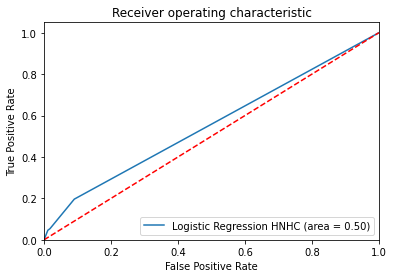

In [35]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression HNHC (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_HNHC_ROC_10')
plt.show()

In [36]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.08377624, 0.08324099, 0.08342099, 0.10269427, 0.09373641,
       0.08407211, 0.08379054, 0.07737732, 0.08863306, 0.08776522]), 'score_time': array([0.00801182, 0.00621867, 0.00798059, 0.00698113, 0.008986  ,
       0.00797796, 0.00701571, 0.00694513, 0.00716257, 0.00797987]), 'test_roc_auc': array([0.54701663, 0.56013942, 0.55880617, 0.56135254, 0.53961185,
       0.5620036 , 0.54019045, 0.55461962, 0.54615323, 0.55514531]), 'train_roc_auc': array([0.55343683, 0.55193478, 0.55212931, 0.55184482, 0.55425801,
       0.55173255, 0.55416062, 0.55265   , 0.55349141, 0.5525341 ]), 'test_precision': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_precision': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_recall': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_recall': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_accuracy': array([0.90023202, 0.90044294, 0.90063291, 0.90063291, 0.90042194,
       0.90042194, 0.90042194, 0.90042194, 0.900

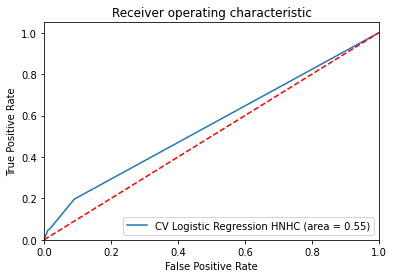

In [37]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_HNHC_ROC_10')
plt.show()

In [38]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(0.779996508227251, 'cm_renlfail'),
 (0.8186704523758669, 'cm_lymph'),
 (0.8539609606901926, 'new_osteo_adm'),
 (0.9038559204600968, 'cm_para'),
 (1.229415254776486, 'cm_ulcer')]

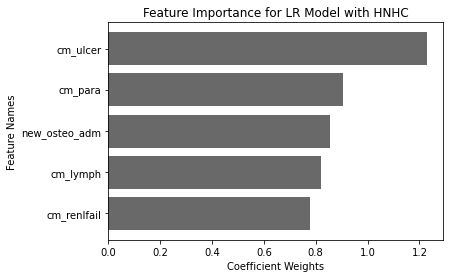

In [39]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for LR Model with HNHC')
plt.savefig('images\Logistic_Regression_HNHC_Feature_Importance_10')
plt.show()

## Target: HNHC without 'los' <a class="anchor" id="lrhnhcnolos"></a> 

[Return to Table of Contents](#contents)

In [40]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['severe_IBD_hospitalization' 'cm_lymph' 'cm_ulcer' 'pq1_dm_short'
 'new_meningitis_adm']


In [41]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,hnhc_patients,severe_IBD_hospitalization,cm_lymph,cm_ulcer,pq1_dm_short,new_meningitis_adm
0,0,0,0,0,0,0
3,0,0,0,0,0,0
4,1,0,0,0,0,0
9,0,0,0,0,0,0
10,0,0,0,0,0,0
...,...,...,...,...,...,...
94491,0,0,0,0,0,0
94492,0,0,0,0,0,0
94493,1,1,0,0,0,0
94496,0,0,0,0,0,0


In [42]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47402, dtype: int64

In [43]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['severe_IBD_hospitalization', 'cm_lymph', 'cm_ulcer', 'pq1_dm_short',
       'new_meningitis_adm'],
      dtype='object')

In [44]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.8994964979888048
Testing Score: 0.9031305375073834


In [45]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

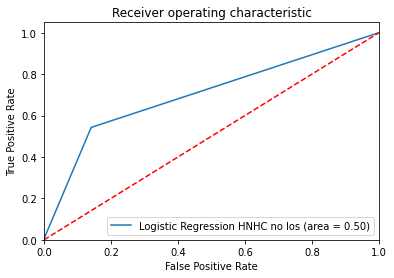

In [46]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression HNHC no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_HNHC_no_los_ROC_10')
plt.show()

In [47]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.11169863, 0.09674144, 0.09377027, 0.11695004, 0.0892458 ,
       0.08606744, 0.08483577, 0.08191037, 0.07774353, 0.1099813 ]), 'score_time': array([0.00797796, 0.00900602, 0.0061667 , 0.00672245, 0.00717521,
       0.00662303, 0.00792027, 0.00668001, 0.00698137, 0.00677729]), 'test_roc_auc': array([0.70265359, 0.67403775, 0.69585701, 0.7309647 , 0.71293714,
       0.72013819, 0.72084482, 0.69569287, 0.70589741, 0.71057748]), 'train_roc_auc': array([0.70745333, 0.71062689, 0.70820455, 0.704303  , 0.70630452,
       0.70550698, 0.70542214, 0.70821958, 0.70708521, 0.70656836]), 'test_precision': array([0.        , 0.30769231, 0.        , 0.        , 0.        ,
       0.        , 0.2       , 0.        , 0.44444444, 0.        ]), 'train_precision': array([0.25      , 0.53623188, 0.25      , 0.28571429, 0.53846154,
       0.28571429, 0.515625  , 0.        , 0.5       , 0.4       ]), 'test_recall': array([0.        , 0.00847458, 0.        , 0.        , 0.        ,
     

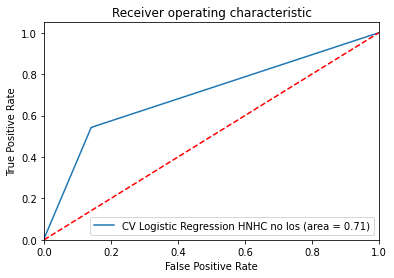

In [48]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_HNHC_no_los_ROC_10')
plt.show()

In [49]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-0.7975413499163202, 'new_meningitis_adm'),
 (0.6417466158691053, 'cm_ulcer'),
 (0.8247832250493534, 'cm_lymph'),
 (1.1457644460047889, 'pq1_dm_short'),
 (2.005055394583752, 'severe_IBD_hospitalization')]

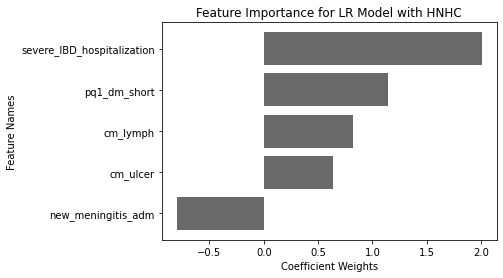

In [50]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for LR Model with HNHC no los')
plt.savefig('images\Logistic_Regression_HNHC_no_los_Feature_Importance_10')
plt.show()

## Target: IBD_READM <a class="anchor" id="lrreadm"></a>

[Return to Table of Contents](#contents)

In [51]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['pq16_dm_amputate' 'new_cardiacarrest_adm' 'new_meningitis_adm'
 'new_atypicalmyco_adm' 'chronic_pain']


In [52]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,ibd_readm,pq16_dm_amputate,new_cardiacarrest_adm,new_meningitis_adm,new_atypicalmyco_adm,chronic_pain
0,1,0,0,0,0,0
3,0,0,0,0,0,0
4,1,0,0,0,0,0
9,0,0,0,0,0,0
10,0,0,0,0,0,0
...,...,...,...,...,...,...
94491,0,0,0,0,0,0
94492,0,0,0,0,0,0
94493,1,0,0,0,0,0
94496,0,0,0,0,0,0


In [53]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47402, dtype: int64

In [54]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['pq16_dm_amputate', 'new_cardiacarrest_adm', 'new_meningitis_adm',
       'new_atypicalmyco_adm', 'chronic_pain'],
      dtype='object')

In [55]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.588309752186999
Testing Score: 0.5973335583495064


In [56]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

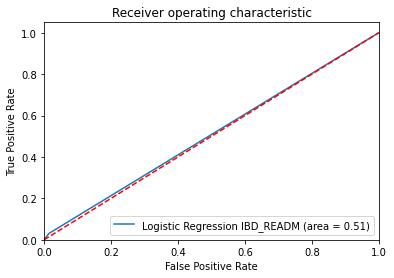

In [57]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression IBD_READM (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_IBD_READM_ROC_10')
plt.show()

In [58]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.07478809, 0.09806108, 0.0672226 , 0.0775094 , 0.06884503,
       0.07064414, 0.06707382, 0.06848049, 0.06217003, 0.08579707]), 'score_time': array([0.00797796, 0.00794649, 0.00775266, 0.00846457, 0.0068531 ,
       0.00791216, 0.00819898, 0.00726795, 0.00762534, 0.0086925 ]), 'test_roc_auc': array([0.50555186, 0.51261788, 0.50961697, 0.51035129, 0.51035752,
       0.50895057, 0.50781158, 0.50811256, 0.51057457, 0.51235901]), 'train_roc_auc': array([0.51008605, 0.50930084, 0.50963416, 0.50955261, 0.50955223,
       0.50970838, 0.5098348 , 0.50980125, 0.50952267, 0.50932976]), 'test_precision': array([0.53846154, 0.65178571, 0.59322034, 0.60869565, 0.58914729,
       0.57264957, 0.55833333, 0.56756757, 0.61682243, 0.64912281]), 'train_precision': array([0.60019175, 0.5890411 , 0.59547244, 0.59371933, 0.5960199 ,
       0.59783677, 0.59960552, 0.59824047, 0.59298929, 0.58921569]), 'test_recall': array([0.02496179, 0.03718798, 0.0356597 , 0.0356597 , 0.03873598,
     

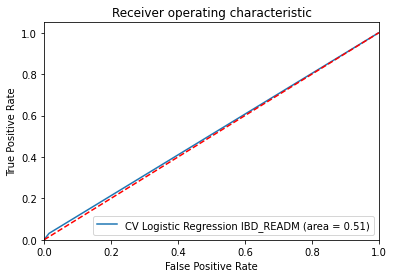

In [59]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_IBD_READM_ROC_10')
plt.show()

In [60]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-1.736714235746804, 'new_cardiacarrest_adm'),
 (-1.0197364089443375, 'new_meningitis_adm'),
 (0.7233974359414886, 'chronic_pain'),
 (0.8275969148329826, 'new_atypicalmyco_adm'),
 (1.1233587988396014, 'pq16_dm_amputate')]

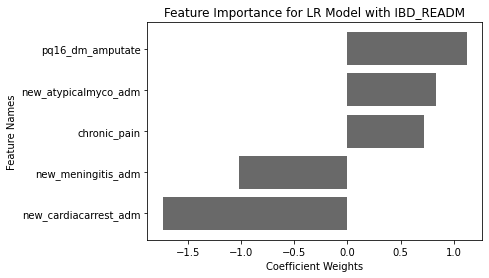

In [61]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for LR Model with IBD_READM')
plt.savefig('images\Logistic_Regression_IBD_READM_Feature_Importance_10')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="lrreadmnolos"></a>

[Return to Table of Contents](#contents)

In [102]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['pq16_dm_amputate' 'new_cardiacarrest_adm' 'new_meningitis_adm'
 'new_atypicalmyco_adm' 'chronic_pain']


In [103]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,ibd_readm,pq16_dm_amputate,new_cardiacarrest_adm,new_meningitis_adm,new_atypicalmyco_adm,chronic_pain
0,1,0,0,0,0,0
3,0,0,0,0,0,0
4,1,0,0,0,0,0
9,0,0,0,0,0,0
10,0,0,0,0,0,0
...,...,...,...,...,...,...
94491,0,0,0,0,0,0
94492,0,0,0,0,0,0
94493,1,0,0,0,0,0
94496,0,0,0,0,0,0


In [104]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47402, dtype: int64

In [105]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['pq16_dm_amputate', 'new_cardiacarrest_adm', 'new_meningitis_adm',
       'new_atypicalmyco_adm', 'chronic_pain'],
      dtype='object')

In [106]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.588309752186999
Testing Score: 0.5973335583495064


In [107]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

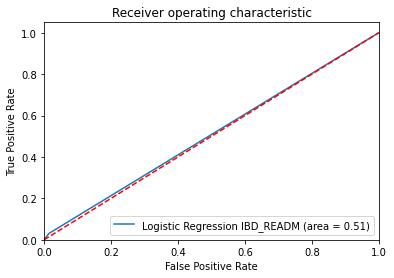

In [108]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression IBD_READM no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_IBD_READM_no_los_ROC_10')
plt.show()

In [109]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.10670424, 0.12367034, 0.10073161, 0.11372662, 0.08976245,
       0.09276462, 0.08576989, 0.08975744, 0.08676887, 0.11067009]), 'score_time': array([0.00997233, 0.01097608, 0.009974  , 0.00894117, 0.01097083,
       0.00899577, 0.0100069 , 0.00897598, 0.00900745, 0.00900984]), 'test_roc_auc': array([0.50555186, 0.51261788, 0.50961697, 0.51035129, 0.51035752,
       0.50895057, 0.50781158, 0.50811256, 0.51057457, 0.51235901]), 'train_roc_auc': array([0.51008605, 0.50930084, 0.50963416, 0.50955261, 0.50955223,
       0.50970838, 0.5098348 , 0.50980125, 0.50952267, 0.50932976]), 'test_precision': array([0.53846154, 0.65178571, 0.59322034, 0.60869565, 0.58914729,
       0.57264957, 0.55833333, 0.56756757, 0.61682243, 0.64912281]), 'train_precision': array([0.60019175, 0.5890411 , 0.59547244, 0.59371933, 0.5960199 ,
       0.59783677, 0.59960552, 0.59824047, 0.59298929, 0.58921569]), 'test_recall': array([0.02496179, 0.03718798, 0.0356597 , 0.0356597 , 0.03873598,
     

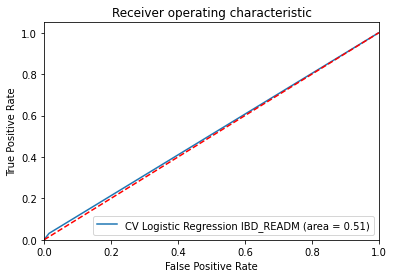

In [110]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_IBD_READM_no_los_ROC_10')
plt.show()

In [111]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-1.736714235746804, 'new_cardiacarrest_adm'),
 (-1.0197364089443375, 'new_meningitis_adm'),
 (0.7233974359414886, 'chronic_pain'),
 (0.8275969148329826, 'new_atypicalmyco_adm'),
 (1.1233587988396014, 'pq16_dm_amputate')]

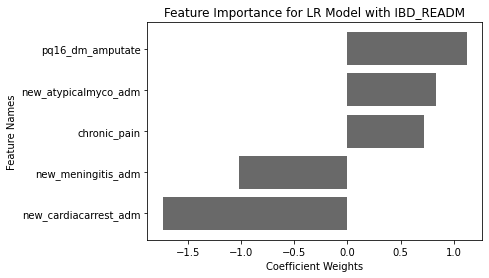

In [112]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for LR Model with IBD_READM no los')
plt.savefig('images\Logistic_Regression_IBD_READM_no_los_Feature_Importance_10')
plt.show()

## Decision Tree Classifier RFE <a class="anchor" id="decisiontreerfe"></a> 

## Target: HNHC <a class="anchor" id="dthnhc"></a>

[Return to Table of Contents](#contents)

In [62]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=10)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_5 = cleaned_data_hnhc.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'los' 'zipinc_qrtl' 'cc_index' 'frailty_risk_score']


In [63]:
# Feature list from RFE results
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

,hnhc_patients,age,los,zipinc_qrtl,cc_index,frailty_risk_score
0,0,89,4,4.0,2,4.7
3,0,48,4,3.0,0,0.5
4,1,65,5,2.0,0,5.7
9,0,51,3,4.0,0,2.8
10,0,22,6,2.0,0,3.8
...,...,...,...,...,...,...
94491,0,32,3,4.0,0,0.0
94492,0,54,4,4.0,0,0.0
94493,1,44,9,4.0,0,0.0
94496,0,52,2,1.0,2,1.5


In [64]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["hnhc_patients"]
target_names_selected = ["none", "hnhc"]
target_selected = target_selected.astype('int64')
target_selected

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46685, dtype: int64

In [65]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('hnhc_patients', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'los', 'zipinc_qrtl', 'cc_index', 'frailty_risk_score'], dtype='object')

In [66]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9934310113386456
Testing Score: 0.8564941740918437


In [67]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

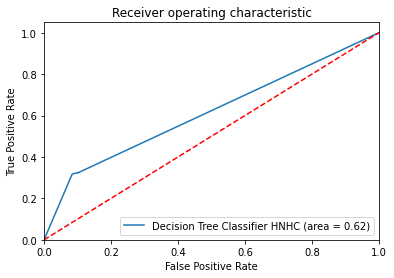

In [68]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier HNHC (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_HNHC_ROC_10')
plt.show()

In [73]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.03290987, 0.0329113 , 0.03191447, 0.0329113 , 0.03291035,
       0.03191447, 0.03191614, 0.03091645, 0.03291249, 0.03191519]), 'score_time': array([0.01000738, 0.00797915, 0.00997353, 0.00797844, 0.00797939,
       0.00797868, 0.00797749, 0.00897646, 0.0089736 , 0.0079782 ]), 'test_roc_auc': array([0.7820826 , 0.76068491, 0.76739127, 0.8058173 , 0.76650809,
       0.78812025, 0.78196309, 0.77968053, 0.78509871, 0.78421823]), 'train_roc_auc': array([0.78873299, 0.79165612, 0.78748746, 0.78618899, 0.79007543,
       0.78826577, 0.78871635, 0.78604497, 0.78873995, 0.78701421]), 'test_precision': array([0.80508475, 0.76470588, 0.76510067, 0.84732824, 0.78512397,
       0.84166667, 0.74342105, 0.80952381, 0.76433121, 0.77372263]), 'train_precision': array([0.82278481, 0.84691137, 0.79023646, 0.84432234, 0.82964225,
       0.85078777, 0.77155172, 0.77540501, 0.79937304, 0.83462532]), 'test_recall': array([0.20430108, 0.16774194, 0.24516129, 0.23870968, 0.20430108,
     

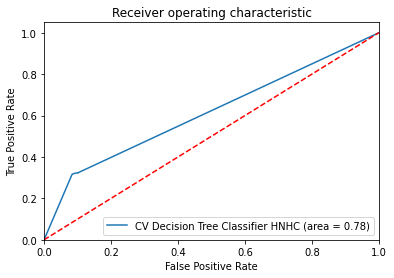

In [74]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_ROC_10')
plt.show()

In [75]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.057789326942532915, 'cc_index'),
 (0.08822725247179018, 'zipinc_qrtl'),
 (0.24670985001742202, 'age'),
 (0.29368366341737734, 'frailty_risk_score'),
 (0.3135899071508776, 'los')]

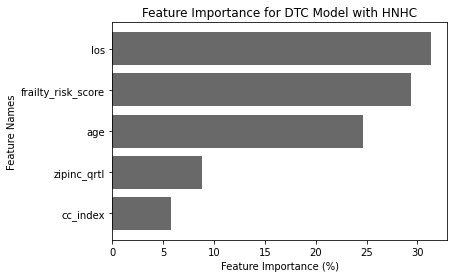

In [76]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for DTC Model with HNHC')
plt.savefig('images\Decision_Tree_Classifier_HNHC_Feature_Importance_10')
plt.show()

## Target: HNHC without 'los' <a class="anchor" id="dthnhcnolos"></a>

[Return to Table of Contents](#contents)

In [77]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=10)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_5 = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'zipinc_qrtl' 'severe_IBD_hospitalization' 'frailty_risk_score'
 'hosp_ur_teach']


In [78]:
# Feature list from RFE results
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

,hnhc_patients,age,zipinc_qrtl,severe_IBD_hospitalization,frailty_risk_score,hosp_ur_teach
0,0,89,4.0,0,4.7,1
3,0,48,3.0,0,0.5,1
4,1,65,2.0,0,5.7,1
9,0,51,4.0,0,2.8,1
10,0,22,2.0,0,3.8,1
...,...,...,...,...,...,...
94491,0,32,4.0,0,0.0,1
94492,0,54,4.0,0,0.0,1
94493,1,44,4.0,1,0.0,1
94496,0,52,1.0,0,1.5,0


In [79]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["hnhc_patients"]
target_names_selected = ["none", "hnhc"]
target_selected = target_selected.astype('int64')
target_selected

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46685, dtype: int64

In [80]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('hnhc_patients', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'zipinc_qrtl', 'severe_IBD_hospitalization',
       'frailty_risk_score', 'hosp_ur_teach'],
      dtype='object')

In [81]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9781224116756633
Testing Score: 0.8494688142563399


In [82]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

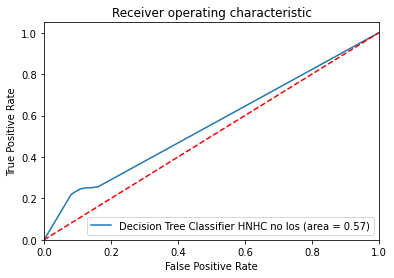

In [83]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier HNHC no los (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_HNHC_no_los_ROC_10')
plt.show()

In [84]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.0369029 , 0.03390741, 0.03391051, 0.02989459, 0.02792144,
       0.02888989, 0.02891564, 0.03088737, 0.02789664, 0.02694511]), 'score_time': array([0.00801349, 0.00897503, 0.00897503, 0.00899887, 0.00897574,
       0.00900865, 0.00794601, 0.00900531, 0.00998688, 0.00897169]), 'test_roc_auc': array([0.73729704, 0.71074169, 0.73117052, 0.75962652, 0.72821634,
       0.75010022, 0.75848586, 0.74470076, 0.7339536 , 0.75379847]), 'train_roc_auc': array([0.75381478, 0.75671857, 0.75500179, 0.75236826, 0.75529161,
       0.75383427, 0.75279184, 0.75309005, 0.75382139, 0.75249041]), 'test_precision': array([0.71428571, 0.5       , 0.47058824, 0.47058824, 0.8       ,
       0.58333333, 0.36363636, 0.6875    , 0.81481481, 0.72222222]), 'train_precision': array([0.61744966, 0.64335664, 0.64189189, 0.64383562, 0.65060241,
       0.62913907, 0.64473684, 0.61904762, 0.58823529, 0.60645161]), 'test_recall': array([0.02150538, 0.02150538, 0.0172043 , 0.0172043 , 0.00860215,
     

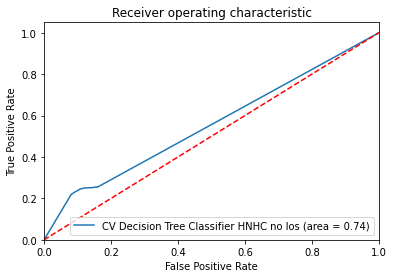

In [85]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_no_los_ROC_10')
plt.show()

In [86]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.06886508687030823, 'hosp_ur_teach'),
 (0.09697735206340176, 'zipinc_qrtl'),
 (0.11613920344432023, 'severe_IBD_hospitalization'),
 (0.3507514047765025, 'age'),
 (0.36726695284546734, 'frailty_risk_score')]

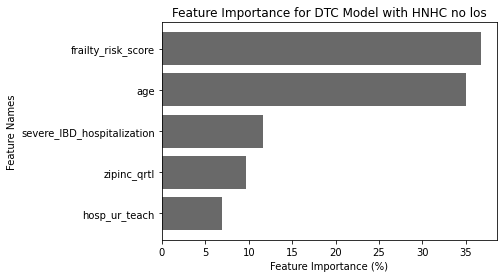

In [87]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for DTC Model with HNHC no los')
plt.savefig('images\Decision_Tree_Classifier_HNHC_no_los_Feature_Importance_10')
plt.show()

## Target: IBD_READM <a class="anchor" id="dtreadm"></a>

[Return to Table of Contents](#contents)

In [88]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=10)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_5 = cleaned_data_readmit.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'los' 'zipinc_qrtl' 'frailty_risk_score' 'h_contrl']


In [89]:
# Feature list from RFE results
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

,ibd_readm,age,los,zipinc_qrtl,frailty_risk_score,h_contrl
0,1,89,4,4.0,4.7,1
3,0,48,4,3.0,0.5,1
4,1,65,5,2.0,5.7,2
9,0,51,3,4.0,2.8,2
10,0,22,6,2.0,3.8,2
...,...,...,...,...,...,...
94491,0,32,3,4.0,0.0,2
94492,0,54,4,4.0,0.0,2
94493,1,44,9,4.0,0.0,2
94496,0,52,2,1.0,1.5,2


In [90]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["ibd_readm"]
target_names_selected = ["none", "ibd_readm"]
target_selected = target_selected.astype('int64')
target_selected

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46685, dtype: int64

In [91]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('ibd_readm', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'los', 'zipinc_qrtl', 'frailty_risk_score', 'h_contrl'], dtype='object')

In [92]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9512181189843772
Testing Score: 0.532128169979438


In [93]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

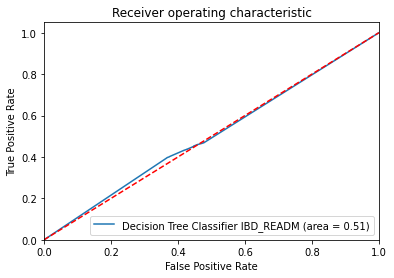

In [94]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier IBD_READM (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_ROC_10')
plt.show()

In [95]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.0309155 , 0.0368669 , 0.036901  , 0.03287816, 0.03291202,
       0.03088355, 0.0309453 , 0.03188086, 0.03188014, 0.03091884]), 'score_time': array([0.00997376, 0.00897408, 0.01197052, 0.00897813, 0.00897503,
       0.01000643, 0.00898147, 0.00901031, 0.0090065 , 0.00897646]), 'test_roc_auc': array([0.58482798, 0.58224566, 0.5737519 , 0.58681724, 0.5801351 ,
       0.57980327, 0.57446851, 0.5959926 , 0.59810995, 0.57169034]), 'train_roc_auc': array([0.59388154, 0.59298318, 0.59540189, 0.5929975 , 0.59278767,
       0.59395431, 0.59573875, 0.59196554, 0.59366919, 0.59518004]), 'test_precision': array([0.52787456, 0.50642674, 0.49931787, 0.52941176, 0.528     ,
       0.52164009, 0.53030303, 0.55373134, 0.52259887, 0.53343949]), 'train_precision': array([0.54011976, 0.53461538, 0.53616583, 0.52101517, 0.5337239 ,
       0.51991375, 0.53644584, 0.53594879, 0.53049229, 0.53904762]), 'test_recall': array([0.1568323 , 0.20393375, 0.18944099, 0.22360248, 0.20507509,
     

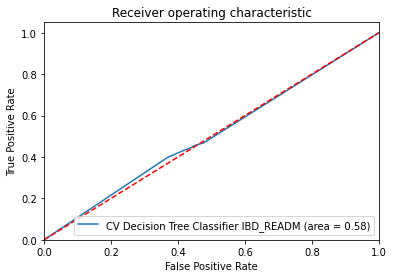

In [96]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_ROC_10')
plt.show()

In [97]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.08027221450407623, 'h_contrl'),
 (0.08949890147867047, 'zipinc_qrtl'),
 (0.15623789031309973, 'los'),
 (0.30454618852764126, 'frailty_risk_score'),
 (0.3694448051765124, 'age')]

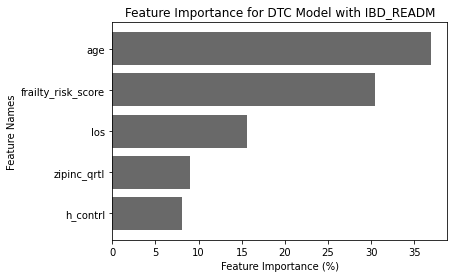

In [98]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for DTC Model with IBD_READM')
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_Feature_Importance_10')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="dtreadmnolos"></a>

[Return to Table of Contents](#contents)

In [113]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=10)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_5 = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'zipinc_qrtl' 'frailty_risk_score' 'h_contrl' 'hosp_bedsize']


In [114]:
# Feature list from RFE results
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

,ibd_readm,age,zipinc_qrtl,frailty_risk_score,h_contrl,hosp_bedsize
0,1,89,4.0,4.7,1,3
3,0,48,3.0,0.5,1,3
4,1,65,2.0,5.7,2,2
9,0,51,4.0,2.8,2,2
10,0,22,2.0,3.8,2,3
...,...,...,...,...,...,...
94491,0,32,4.0,0.0,2,2
94492,0,54,4.0,0.0,2,3
94493,1,44,4.0,0.0,2,3
94496,0,52,1.0,1.5,2,3


In [115]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["ibd_readm"]
target_names_selected = ["none", "ibd_readm"]
target_selected = target_selected.astype('int64')
target_selected

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46685, dtype: int64

In [116]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('ibd_readm', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'zipinc_qrtl', 'frailty_risk_score', 'h_contrl', 'hosp_bedsize'], dtype='object')

In [117]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9011510010567504
Testing Score: 0.5326422206991089


In [118]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

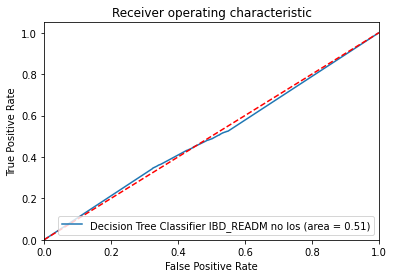

In [119]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier IBD_READM no los (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [120]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.02689958, 0.02891469, 0.02893734, 0.02795911, 0.02492857,
       0.02496123, 0.02391076, 0.02493501, 0.02493405, 0.02392364]), 'score_time': array([0.00897646, 0.00797963, 0.00897455, 0.00798178, 0.00797868,
       0.00698113, 0.00800347, 0.00697947, 0.00697923, 0.00798678]), 'test_roc_auc': array([0.56212173, 0.56157898, 0.55021092, 0.57581048, 0.56225707,
       0.55649285, 0.54863857, 0.57014876, 0.56526015, 0.54836072]), 'train_roc_auc': array([0.57384151, 0.574184  , 0.57474237, 0.57204411, 0.57428066,
       0.57392969, 0.57513781, 0.57158172, 0.57339539, 0.57490569]), 'test_precision': array([0.49507389, 0.47560976, 0.48027842, 0.46838407, 0.46538462,
       0.43661972, 0.48201439, 0.51483051, 0.52488688, 0.48561151]), 'train_precision': array([0.52228261, 0.5200199 , 0.51586515, 0.51484108, 0.51427389,
       0.54392237, 0.5184582 , 0.50606133, 0.51279686, 0.5294378 ]), 'test_recall': array([0.10403727, 0.12111801, 0.10714286, 0.10351967, 0.06266183,
     

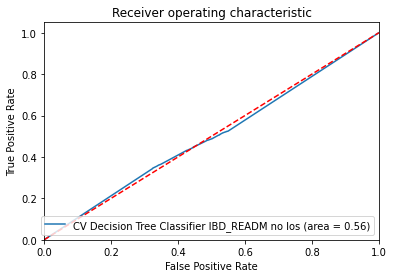

In [121]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [122]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.08010650788130194, 'hosp_bedsize'),
 (0.08395136991538436, 'zipinc_qrtl'),
 (0.09120417897681359, 'h_contrl'),
 (0.348824706094136, 'frailty_risk_score'),
 (0.395913237132364, 'age')]

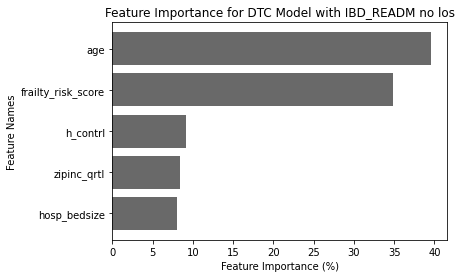

In [123]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for DTC Model with IBD_READM no los')
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_no_los_Feature_Importance_10')
plt.show()

## XGBoost Classifier Model <a class="anchor" id="xgboostrfe"></a> 

## Target: HNHC <a class="anchor" id="xgbhnhc"></a>

[Return to Table of Contents](#contents)

In [124]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

 was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if 

In [125]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,hnhc_patients,los,orproc,payer,cm_dmcx,chronic_pain
0,0,4,0,1.0,0,0
3,0,4,1,2.0,0,0
4,1,5,0,1.0,0,0
9,0,3,1,2.0,0,0
10,0,6,1,1.0,0,0
...,...,...,...,...,...,...
94491,0,3,0,2.0,0,0
94492,0,4,1,2.0,0,0
94493,1,9,1,2.0,0,0
94496,0,2,1,1.0,0,0


In [126]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47349, dtype: int64

In [127]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['los', 'orproc', 'payer', 'cm_dmcx', 'chronic_pain'], dtype='object')

In [128]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[17:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.9192081326912788
Testing Score: 0.9192431153911134


In [129]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

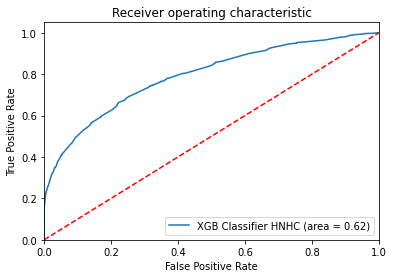

In [130]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier HNHC (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_HNHC_ROC_10')
plt.show()

In [131]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[17:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

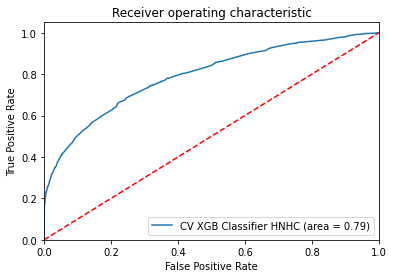

In [132]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_HNHC_ROC_10')
plt.show()

In [133]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.04951981, 'cm_dmcx'),
 (0.05810878, 'payer'),
 (0.058204513, 'chronic_pain'),
 (0.116038345, 'orproc'),
 (0.71812856, 'los')]

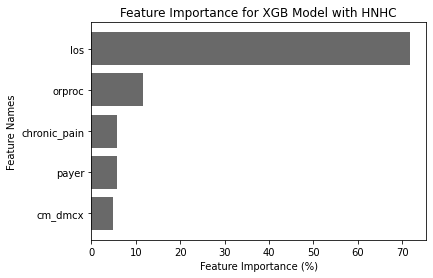

In [134]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for XGB Model with HNHC')
plt.savefig('images\XGB_Classifier_HNHC_Feature_Importance_10')
plt.show()

## Target: HNHC no 'los' <a class="anchor" id="xgbhnhcnolos"></a>

[Return to Table of Contents](#contents)

In [135]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

loss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old beh

In [136]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,hnhc_patients,orproc,payer,severe_IBD_hospitalization,cm_wghtloss,blood_transfusion
0,0,0,1.0,0,0,0
3,0,1,2.0,0,0,0
4,1,0,1.0,0,0,0
9,0,1,2.0,0,0,0
10,0,1,1.0,0,0,0
...,...,...,...,...,...,...
94491,0,0,2.0,0,0,0
94492,0,1,2.0,0,0,0
94493,1,1,2.0,1,0,1
94496,0,1,1.0,0,0,0


In [137]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47349, dtype: int64

In [138]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['orproc', 'payer', 'severe_IBD_hospitalization', 'cm_wghtloss',
       'blood_transfusion'],
      dtype='object')

In [139]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[18:06:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.9003407394891724
Testing Score: 0.9033620544010813


In [140]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

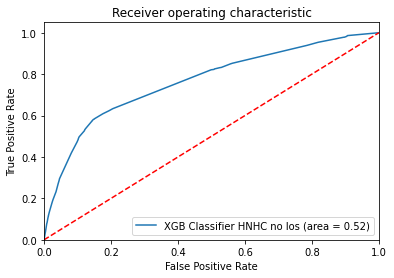

In [141]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier HNHC no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_HNHC_no_los_ROC_10')
plt.show()

In [142]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[18:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:06:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:06:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:06:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

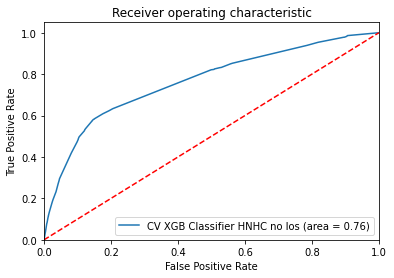

In [143]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_HNHC_no_los_ROC_10')
plt.show()

In [144]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.017268999, 'cm_wghtloss'),
 (0.030519407, 'payer'),
 (0.032813348, 'orproc'),
 (0.034536164, 'blood_transfusion'),
 (0.884862, 'severe_IBD_hospitalization')]

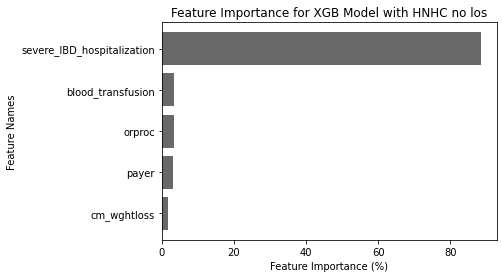

In [145]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for XGB Model with HNHC no los')
plt.savefig('images\XGB_Classifier_HNHC_no_los_Feature_Importance_10')
plt.show()

## Target: IBD_READM <a class="anchor" id="xgbreadm"></a>

[Return to Table of Contents](#contents)

In [146]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

m 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:07:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to re

In [147]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,ibd_readm,elective,orproc,payer,ibd_procedures,ibd_specific_adm
0,1,0.0,0,1.0,0,0
3,0,1.0,1,2.0,1,1
4,1,0.0,0,1.0,0,1
9,0,0.0,1,2.0,0,0
10,0,1.0,1,1.0,1,0
...,...,...,...,...,...,...
94491,0,0.0,0,2.0,0,0
94492,0,1.0,1,2.0,1,0
94493,1,1.0,1,2.0,1,1
94496,0,1.0,1,1.0,0,0


In [148]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47303, dtype: int64

In [149]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['elective', 'orproc', 'payer', 'ibd_procedures', 'ibd_specific_adm'], dtype='object')

In [150]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[18:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.5877047100938636
Testing Score: 0.5918315575849823


In [151]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

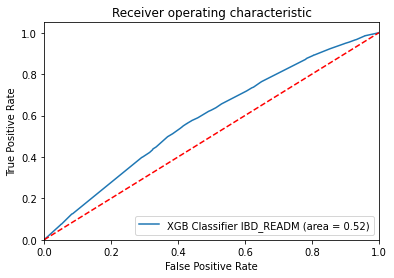

In [152]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier IBD_READM (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_IBD_READM_ROC_10')
plt.show()

In [153]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[18:09:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

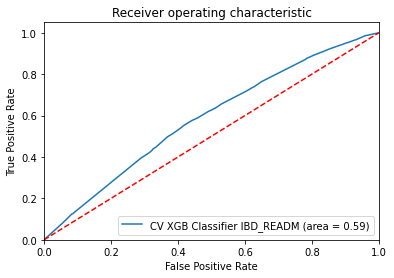

In [154]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_IBD_READM_ROC_10')
plt.show()

In [155]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.06308964, 'ibd_specific_adm'),
 (0.06867511, 'elective'),
 (0.15328604, 'ibd_procedures'),
 (0.3195638, 'orproc'),
 (0.39538535, 'payer')]

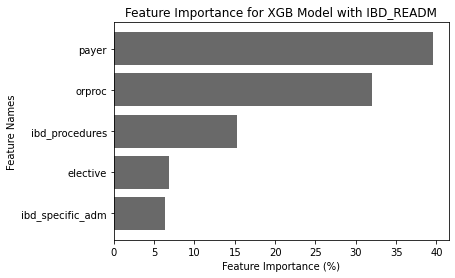

In [156]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for XGB Model with IBD_READM')
plt.savefig('images\XGB_Classifier_IBD_READM_Feature_Importance_10')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="xgbreadmnolos"></a>

[Return to Table of Contents](#contents)

In [157]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the 

In [158]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,ibd_readm,orproc,payer,severe_IBD_hospitalization,cm_anemdef,chronic_pain
0,1,0,1.0,0,1,0
3,0,1,2.0,0,0,0
4,1,0,1.0,0,1,0
9,0,1,2.0,0,0,0
10,0,1,1.0,0,0,0
...,...,...,...,...,...,...
94491,0,0,2.0,0,0,0
94492,0,1,2.0,0,0,0
94493,1,1,2.0,1,0,0
94496,0,1,1.0,0,0,0


In [159]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47349, dtype: int64

In [160]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['orproc', 'payer', 'severe_IBD_hospitalization', 'cm_anemdef',
       'chronic_pain'],
      dtype='object')

In [161]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[18:12:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.6017008814170257
Testing Score: 0.5984963676296672


In [162]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

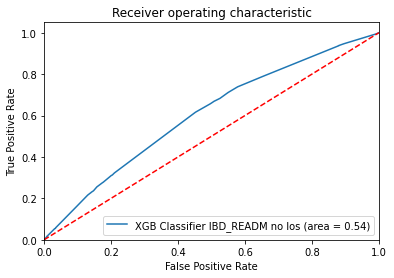

In [163]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier IBD_READM no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [164]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[18:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

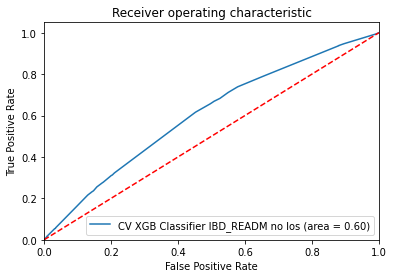

In [165]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [166]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.09491325, 'chronic_pain'),
 (0.15039186, 'cm_anemdef'),
 (0.23092468, 'orproc'),
 (0.25167274, 'severe_IBD_hospitalization'),
 (0.27209747, 'payer')]

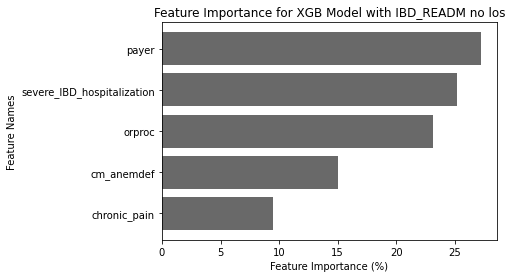

In [167]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for XGB Model with IBD_READM no los')
plt.savefig('images\XGB_Classifier_IBD_READM_no_los_Feature_Importance_10')
plt.show()